In [1]:
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [2]:
#import spike
#from spike.Interactive import INTER as I 
#I.hidecode(message="")
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, plot, figure, text, title, xlabel, ylabel, subplots
import numpy as np
from numpy import exp, cos, sin, arctan2, pi, linspace, arange

import spike
from spike.File import BrukerMS as bkMS

from ipywidgets import Button, interactive, interact, FloatSlider, IntSlider
import ipywidgets as widgets
from IPython.display import display, HTML, Javascript, Markdown, Image

matplotlib.style.use("fivethirtyeight")
for i in ('font.size','axes.labelsize','legend.fontsize','legend.title_fontsize'):
    matplotlib.rcParams[i]=24
for i in ('xtick.labelsize', 'ytick.labelsize'):
    matplotlib.rcParams[i]=18

#matplotlib.style.available


          SPIKE
    Version     : 0.99.29
    Date        : 20-09-2021
    Revision Id : 529
*** zoom3D not loaded ***
plugins loaded:
Fitter,  Linear_prediction,  Peaks,  bcorr,  fastclean,  gaussenh,  rem_ridge,  sane,  sg,  test,  urQRd, 
plugins loaded:
msapmin, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin
plugins loaded:
FTMS_calib,  PhaseMS,  diagonal_2DMS, 
*** PALMA not loaded ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  Integrate,  apmin, 


# 2. The basic FTICR experiment
### 2nd-AUS-FTICR
*Marc-André Delsuc - Prague 26-30 Sept 2021*


This work is licensed under [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

a developed content of this part can be found on [github.com/delsuc](https://github.com/delsuc/Fourier_Transform/blob/master/Definition_Properties.ipynb)

## classical processing

We are going to go slowly through the steps that produced that nice spectrum earlier.

We will use `SPIKE` a processing library written in python, able to handle all sorts of FT spectrometries 


`SPIKE` is freely available on github : [github.com/spike-project/spike](https://github.com/spike-project/spike)

![](files/Logo.png)

*Check a [deeper presentation](https://github.com/delsuc/Spike_in_MS_2021) of `SPIKE` done in Prof P.O'Connor lab in April 2021*


## The process that run on the previous slide

Actually, just a few lines of python

```python
import spike
from spike.File import BrukerMS
d = BrukerMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")
figure(figsize=(16, 3))
d.display(new_fig=False)
D = d.copy().center().kaiser(4).zf(2).rfft().modulus()
figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);


```

Let's go through them slowly...

## First get rid of the syntax problems !

First, load the `SPIKE` environment into this presentation - which is in fact a python program presenting its results in a browser *(amazing if you ask me)* and load the specific tool for reading Bruker FT-ICR files.
```python
import spike
from spike.File import BrukerMS
```

Then, import the raw data-set from the instrument and create `d` a python object - and display. <br>
The program takes care of handling all the acquisition parameters.

```python
d = BrukerMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")
figure(figsize=(16, 3))
d.display(new_fig=False)
```
Then do the processing - *this is where everything takes place*
```python
D = d.copy().center().kaiser(4).zf(2).rfft().modulus()
```

Finally, display the spectrum with a given zoom window
```python
figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);
```


## let's explore the processing
<big> D = d. **copy()** .center().kaiser(4).zf(2).rfft().modulus() </big>

Actions are applied to the object by the mean of the dot " **.** "

in `SPIKE` spectroscopic objects are modified in-place, in order to optimize speed and memory.
 
`d` has been created in memory, we do not want to loose it while doing transformations, so we just `copy()` it <br>and create a new object on which the following actions are applied

<big> D = d.copy().**center().kaiser(4).zf(2).rfft().modulus()** </big>

actions are chained, the whole expression evaluates as the final spectrum.

The processing is done in 5 steps ‼️  ... not just one ❓️

## let's explore the processing - 1 -
<big> D = d.copy(). **center()** .kaiser(4).zf(2).rfft().modulus() </big>

Remember one of the relationships presented in first part: 

#### integrals
$$F_o = \int f(t) dt \quad \quad f_o = \int F(\omega) d \omega$$

So, if a slight miss-adjustment of the 0 of the detector is present, there might be a small continuous constant value added to all measured points.

Added over the whole `fid` this value will show up as a strong spike at $F_o$ the null frequency.

Even if it corresponds to $m/z = \infty$ *(but only in Broad-Band mode)* it might creates round-off errors in the processing because of a very strong dynamics.

So we just compute a **centering** of the data-set to remove this artefact.

## let's explore the processing - 2 -
<big> D = d.copy().center(). **kaiser(4)** .zf(2).rfft().modulus() </big>

This is the very important **Apodisation** step.

It consists in pre-multiplying the `fid ` with some shape, with a strong impact on the lineshape, resolution and noise level in the final spectrum.

It is deeply related to the convolution theorem - which we will go through now...

## Convolution
We have seen that Linearity means that **FT of sum** is the **sum of FT**

if linearity is for addition, convolution is for multiplication.

Convolution of two functions $f$ and $g$ is defined as: (noted it here $*$ )
$$
(f * g)(t') = \int_{-\infty}^{\infty} f(t) g(t-t')dt
$$

Then the convolution theorem states that  **FT of product** is the **convolution of FT**

This is a symmetric operation for $f$ and $g$, and can be described as $f$ and $g$ sharing their shapes.

Difficult to apprehend, Let see it in action:

In [3]:
def ftcv(frequency = 3.0, broadening=2.0, truncating_to=30):
    "showing convolution"
    freq = frequency
    N = truncating_to
    br = broadening
    x = np.linspace(0,10,1000)    # a vector of 1000 points equi distant from 0.0 to 10.0
    y = np.cos(2*np.pi*freq*x)
    g = np.zeros_like(x)
    g[0:N] = 1.0
    apod = g*np.exp(-br*x**2)
    y = y*apod
    YY = np.fft.rfft(y,n=1000)
    yax = np.linspace(0,50,501)
    f, (ax1,ax2) = plt.subplots(nrows=2, figsize=(16,8))
    ax1.plot(apod, ':k', lw=2)
    ax1.plot(y.real)
    ax1.set_ylim(ymin=-1.1, ymax=1.1)
    ax1.set_xlim(xmax=400)
    ax2.plot(yax, abs(YY))
    ax2.set_xlim(xmax=20)
display(Markdown("""## Toy Convolution"""))
interact(ftcv,
        frequency=FloatSlider(min=0, max=20, value=8, continuous_update=False),
        broadening=FloatSlider(min=0,max=5, value=0, continuous_update=False),
        truncating_to=IntSlider(min=20, max=1000, value=1000, continuous_update=False));
#interactive( ftcv, frequency=(0.0,50.0), truncating_to=(4,500), broadening=(0,30))

## Toy Convolution

interactive(children=(FloatSlider(value=8.0, continuous_update=False, description='frequency', max=20.0), Floa…

- the broadening exemplify the *Gabor principle* which states that
    - $\sigma_f \sigma_F \geq \frac 1 {4 \pi} \quad$ where $\sigma$ is the standard deviation (the spreading) of each signals
    - $\Rightarrow$ $f$ and $F$ cannot be slim (or fat) at the same time,
    if one is fat, the other is slim. 

- the truncation shows the same but the FT of the truncature function is the *cardinal sine* :
$$\text{sinc}(x) = \frac {\sin(x)} x$$

## Classical apodisation functions
chosen to limit the truncation effect, while keeping narrow lines

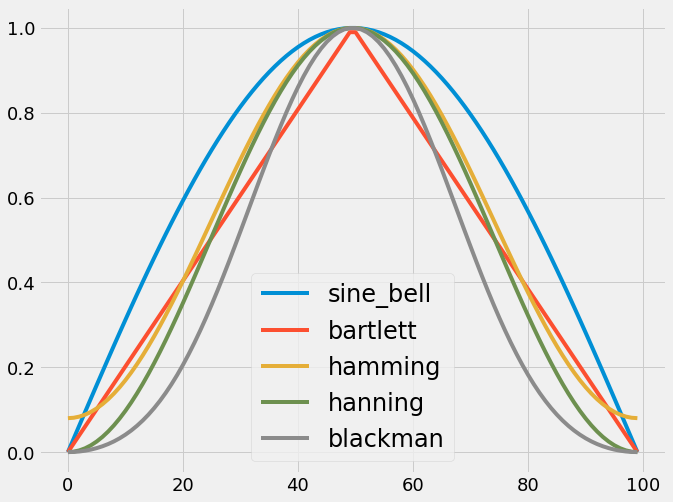

In [4]:
from numpy import blackman, hamming, hanning, bartlett, kaiser  # these are pre-defined
def sine_bell(N):                                       # this one is missing
    "defines the sine-bell apodisation window"
    return np.sin( np.linspace(0,np.pi,N) )
figure(figsize=(10,8))
for apod in ("sine_bell", "bartlett", "hamming", "hanning", "blackman"):
    y = eval("%s(100)"%(apod))
    plt.plot(y,label=apod)
plt.legend();

The **kaiser** function is also very usefull as a generic/tunable apodisation function.

`kaiser(β=...)`

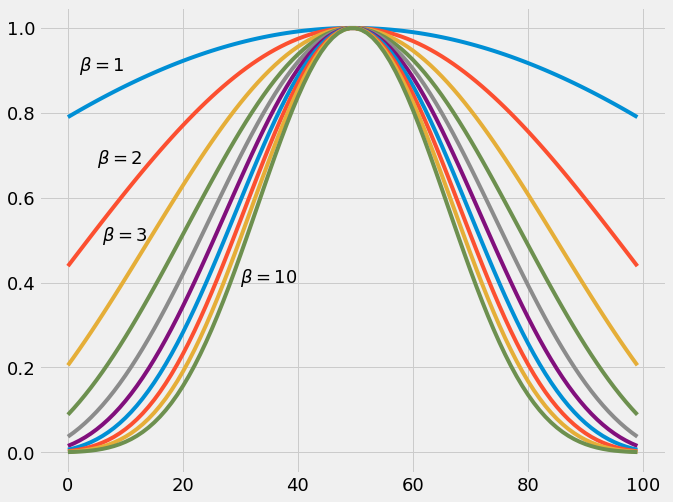

In [5]:
plt.figure(figsize=(10,8))
for beta in range(1,11):
    plt.plot(kaiser(100, beta), label=r"$\beta=%.1f$"%beta)
#plt.legend()
plt.text(2,0.9,r"$\beta=1$",fontsize=18)
plt.text(5,0.68,r"$\beta=2$",fontsize=18)
plt.text(6,0.5,r"$\beta=3$",fontsize=18)
plt.text(30,0.4,r"$\beta=10$",fontsize=18);
#plt.title(r'The Kaiser($\beta$) apodisation');

In [6]:
apodlist = ["None", "sine_bell", "bartlett", "hamming", "hanning", "blackman", "kaiser"]
def ftapod(freq1 = 10.0, freq2 = 20.0, br=0.5, N=150, apod="empty", beta=3.0, noise=0):
    "showing convolution"
    x = np.linspace(0,10,1000)    # a vector of 1000 points equi distant from 0.0 to 10.0
    y = np.cos(2*pi*freq1*x) + np.cos(2*pi*freq2*x)
    g = np.zeros_like(x)
    if apod == 'None':
        g[0:N] = 1.0
    elif apod == 'kaiser':
        g[0:N] = eval("%s(%d,%f)"%(apod,N,beta))
    elif apod != 'None':
        g[0:N] = eval("%s(%d)"%(apod,N))
    y *= np.exp(-br*x**2)
    if noise>0:
        y += noise*np.random.randn(1000)
    ymax = max(y)
    YY = np.fft.rfft(y*g,n=1000)
    yax = np.linspace(0,50,501)
    f, (ax1,ax2) = plt.subplots(nrows=2, figsize=(12,6))
    ax1.plot(ymax*g, ':k', lw=2)
    ax1.plot(y*g)
    ax1.set_ylim(ymin=-1.1*ymax, ymax=1.1*ymax)
    ax1.set_xlim(xmax=400)
    ax2.plot(yax, abs(YY))
    ax2.set_xlim(xmax=20)
display(Markdown("""## Exploring a slightly more realistic signal"""))

from ipywidgets import interactive_output, Dropdown, HBox, VBox, Label
freq1 = FloatSlider(description='Freq1',min=0, max=20, value=13, continuous_update=False)
freq2 = FloatSlider(description='Freq2',min=0, max=20, value=14, continuous_update=False)
beta = FloatSlider(description='β',min=1.0, max=10.0, value=4, continuous_update=False)
truncating_to = IntSlider(description='Truncation to',min=2,max=1000, value=1000, continuous_update=False)
broadening = FloatSlider(description='Broadening',min=0,max=1, value=0, continuous_update=False)
noise = FloatSlider(description='added noise',min=0, max=3, value=0, continuous_update=False)
apodisation = Dropdown(description='Apodisation',options=apodlist)
uibox = VBox([HBox([freq1, freq2]),
              HBox([truncating_to, broadening, noise]),
              HBox([apodisation, beta, Label('(β used by Kaiser only)')])])
out = interactive_output( ftapod,
    {'freq1':freq1, 'freq2':freq2, 'br':broadening, 'N':truncating_to, 'apod':apodisation, 'beta':beta, 'noise':noise})
display(uibox, out)

## Exploring a slightly more realistic signal

Output()

- Explore the effect of truncation and apodisation with respect to signal life-time (broadening) and noise level.
- explore how apodisation may improve the resolving power
- and how it degrades the SNR in the same time

## let's explore the processing - 3 & 4-
<big> D = d.copy().center().kaiser(4). **zf(2)** .rfft().modulus() </big>

- **zerofilling** consists in adding zeros to the data-set *before* FT. 
- what we've seen about truncation is an example
- improves numerical resolution - here doubling the number of points
- Finally, as in take the modulus (in step **5**) which halves the amount of information, it is actually a requisite !
    - *always zerofill at least once*

<big> D = d.copy().center().kaiser(4).zf(2). **rfft()** .modulus() </big>

- This is the Fourier step - this is actually the simpler step -
- `rfft()` **r** is for **real** - we use here an optimized FT - whichs knows that the imaginary part is null
- there are some other subtilities here that we will not discussed *(check `SPIKE` source code !)*



## let's explore the processing - 5 -
<big> D = d.copy().center().kaiser(4).rfft().zf(2). **modulus()** </big>

This step replaces the complex series $X_i$ produced by FT (even `rfft()`) by its modulus $|X_i|$

What happens if we don't do that ?

```python
d = bkMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")
figure(figsize=(16, 3))
d.display(new_fig=False)

D = d.copy().center().kaiser(4).zf(2).rfft()

figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);
```

### we get this

In [7]:
d = bkMS.Import_1D("files/histonepeptide_ms2_000002.d/fid")

D = d.copy().center().kaiser(4).zf(2).rfft()

Using 3 parameters calibration,  Warning calibB is -ML2


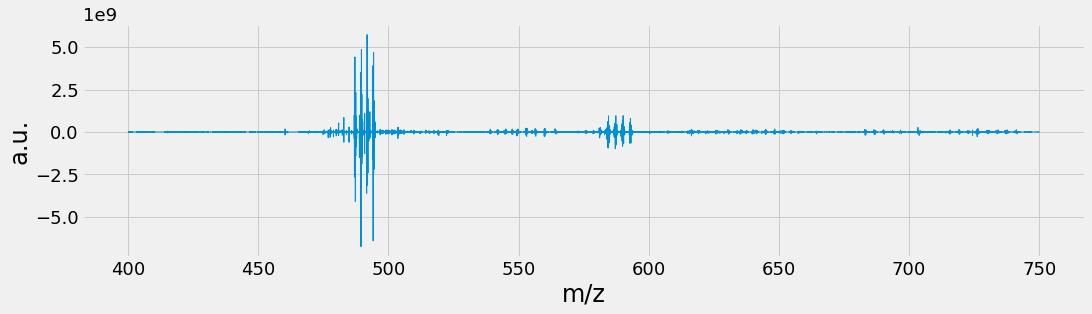

In [8]:
figure(figsize=(16,4))
D.set_unit('m/z').display(zoom=(400,750),new_fig=False);

**What's going on ?**

To find out, we zoom on a peptide pattern

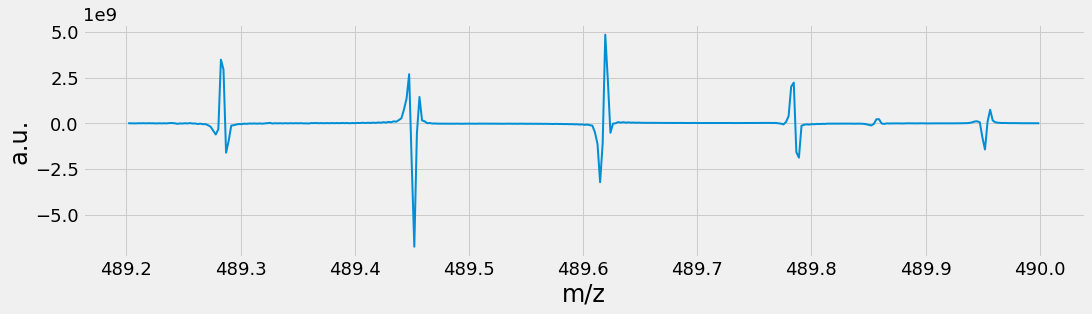

In [9]:
figure(figsize=(16,4))
D.display(zoom=(489.2, 490),linewidth=2, new_fig=False);

to make clearer - let's change the apodisation, for a much smoother one *(that conserves the beginning of the `fid`)* 

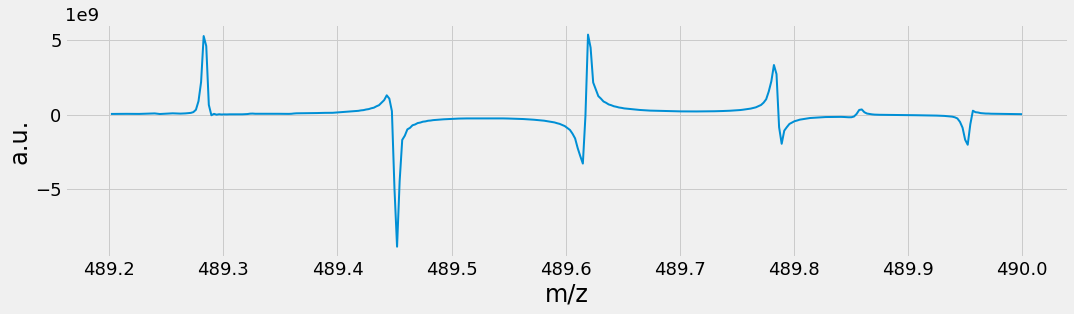

In [10]:
figure(figsize=(16,4))
Dph = d.copy().center().apod_sin(0).zf(2).rfft().set_unit('m/z').display(zoom=(489.2, 490),linewidth=2,new_fig=False);

## FT of a *Causal* signal 
It all comes from the fact that the signal of the `fid` comes from a pulse

- $\Rightarrow$ signal for $t < 0$ is null
- signal is said *Causal*
- its real part is **Absorptive** and decay rapidly
- its real part is **Dispertive** and decay more slowly *(is null for a stationary signal)*

Here is a simulation


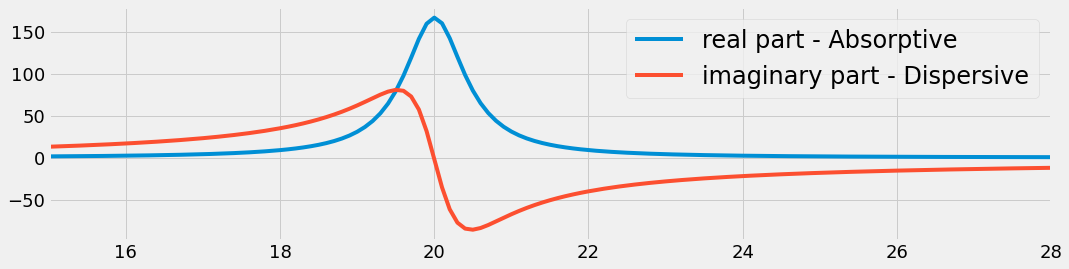

In [11]:
freq = 20
t = linspace(0,10,10000)
y = cos(2*np.pi*freq*t)*exp(-3*t)
YY = np.fft.rfft(y)
figure(figsize=(16,4))
yax = linspace(0,500,len(YY))
plot(yax, YY.real, label='real part - Absorptive')
plot(yax, YY.imag, label='imaginary part - Dispersive')
plt.xlim(xmin=15, xmax=28)
plt.legend();

## dephasing
However, if there is an error on the *t=0* position,  the phase of the time signal is $\neq 0$ 
Then the signal get dephased <br>
here with an error of 70°...

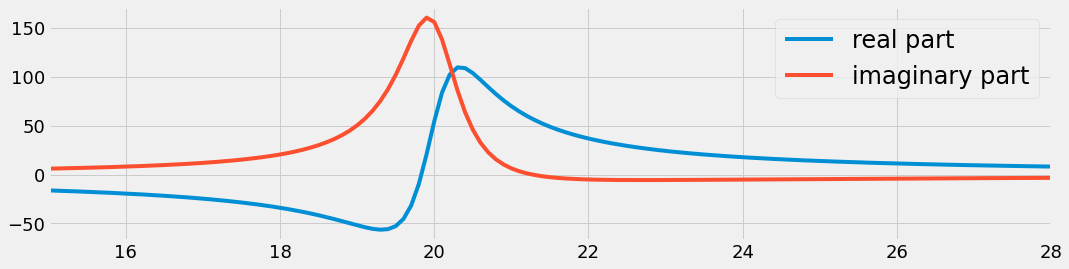

In [12]:
freq = 20
t = linspace(0,10,10000)
y = cos(2*np.pi*freq*t+(7/9)*pi/2)*exp(-3*t)
YY = np.fft.rfft(y)
figure(figsize=(16,4))
yax = linspace(0,500,len(YY))
plot(yax, YY.real, label='real part')
plot(yax, YY.imag, label='imaginary part')
plt.xlim(xmin=15, xmax=28)
plt.legend();

This is exactly what we see here - with each line has a different phase.<br>
Line at $m/z=489.28$ is in absorption - Line at $m/z=489.61$ is in dispersion - other are mixed

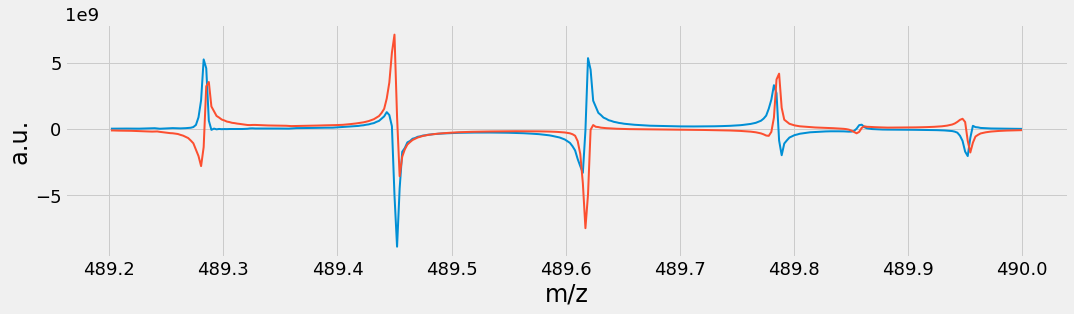

In [13]:
figure(figsize=(16,4))
Dph.display(zoom=(489.2, 490),linewidth=2,new_fig=False);
Dph.phase(90,0).display(zoom=(489.2, 490),linewidth=2,new_fig=False);

### Usual solution is to take the modulus

But then line are as broad as the Dispersive lineshape

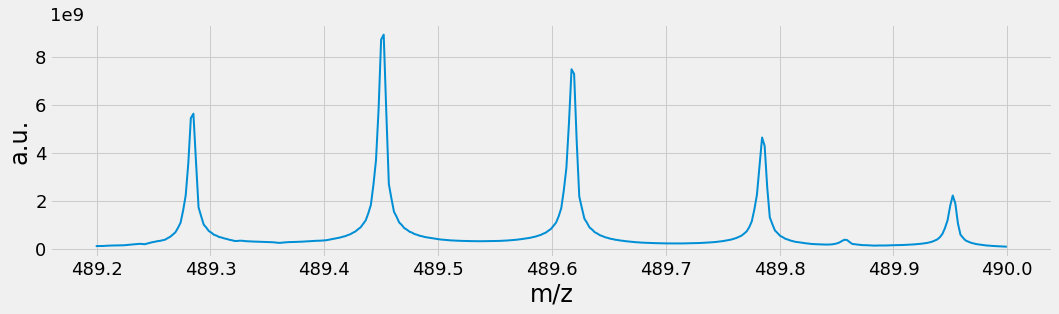

In [14]:
figure(figsize=(16,4))
Dph.modulus().display(zoom=(489.2, 490),linewidth=2,new_fig=False);

and compared to the previous version, strongly apodised - which "compresses" the line to the detriment of SNR

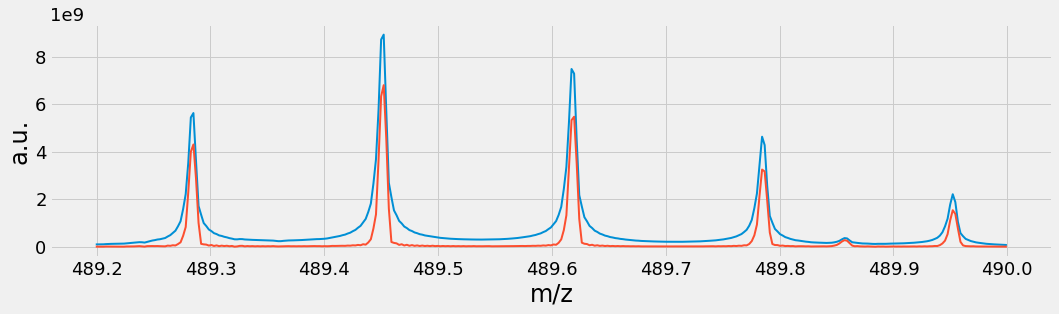

In [15]:
figure(figsize=(16,4))
Dph.display(zoom=(489.2, 490),linewidth=2,new_fig=False)
D.modulus().display(zoom=(489.2, 490),linewidth=2,new_fig=False);

# Absorption mode
- Of course we would prefer to have all lines in absorption, to do that we need to know/find the dependence of phase with peak position.

$$
\phi(\omega) = \phi_o + \phi_1  \omega + \phi_2  \omega^2 
$$

| | cause | effect | oder |
|:---|:----|:---|---|
|$\phi_o$ | error on 0 of phase ref.   | phase error common to all signals | 0th order
|$\phi_1$ | error on t=0 postion     | phase error proportional to frequency | 1st order
|$\phi_2$ | error on ion excitation time | phase error proportional to frequency² | 2nd order

- $\phi_o$ : trivial to correct
- $\phi_1$ : can be estimated, easy to correct - as variation $\frac {d \phi}{d \omega}$ is constant
    - created by a delay after excitation
- $\phi_2$ : can be estimated, difficult to correct - as variation $\frac {d \phi}{d \omega}$ is unbound
    - created by "*chirp*" frequency swept excitation pulses !

### Examples of phase error

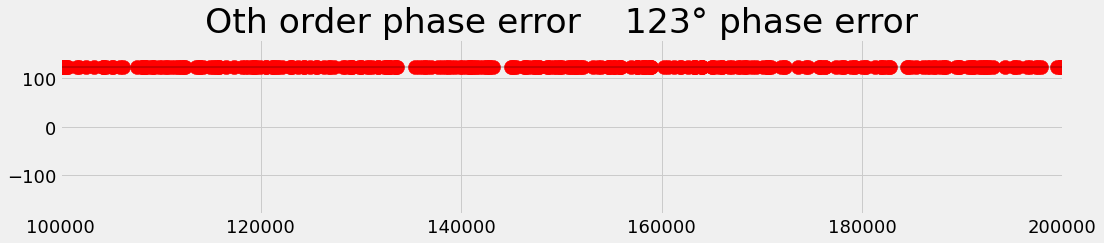

In [16]:
sw = 200000
omega = linspace(0,sw,10000) # freq axis
mz = np.random.randint(5000,10000,300)
ph0=123
phase = ph0*np.ones(10000)
figure(figsize=(16,3))
plot(omega, phase, 'k', lw=2, alpha=0.2)
scatter(omega[mz], phase[mz], 200,'r')
plt.title("Oth order phase error    123° phase error")
plt.xlim(xmin=100000, xmax=200000);
plt.ylim(ymin=-180, ymax=+180);

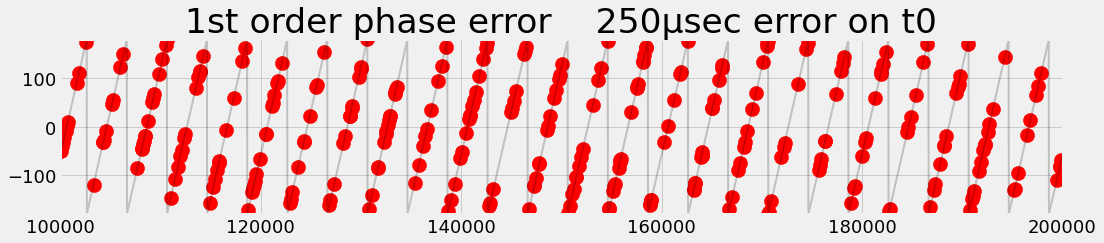

In [17]:
# 200kHz - 400kH Nyq - 2.5 µs sampl - 250µs error = 100 points = 50 turns
ph1 = 50*360/sw
phase = (ph0 + ph1*omega )%360 - 180
figure(figsize=(16,3))
plot(omega, phase, 'k', lw=2, alpha=0.2)
scatter(omega[mz], phase[mz], 200,'r')
plt.title("1st order phase error    250µsec error on t0")
plt.xlim(xmin=100000, xmax=200000)
plt.ylim(ymin=-180, ymax=+180);

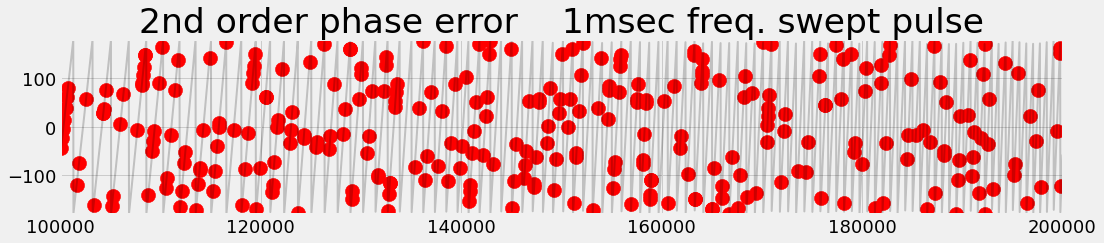

In [18]:
# 1ms pulse
ph1 = -100*360/sw
ph2 = 200*360/sw/sw
phase = (ph0 + ph1*omega +ph2*omega**2)%360 - 180
figure(figsize=(16,3))
plot(omega, phase, 'k', lw=2, alpha=0.2)
scatter(omega[mz], phase[mz], 200,'r')
plt.title("2nd order phase error    1msec freq. swept pulse")

plt.xlim(xmin=100000, xmax=200000);
plt.ylim(ymin=-180, ymax=+180);

phase is random-like

## Getting an absorption spectrum

- use SWIM excitation to generate 1st order only correction, or even $\phi = 0$ 
    - if you are able to !
- adapt the processing (special apodisation for instance)
- use ad-hoc phase correction
    - optimising the excitation pulse - the shorter the better
        - phase rotation induces some artefacts that cannot be corrected
    - compute and apply a phase correction

2 methods for finding the phase correction

## Automatic approach
![](files/autophaser.png)

1. Peak Detection
2. Initial fitting to a reduced m/z range (Followed by the Iterative Tune procedure)
3. Extension of the initial fit (Followed by the Iterative Tune procedure)
4. Fitting of the complete spectrum (Followed by the Iterative Tune procedure)
5. Peak symmetry adjustment
6. Baseline correction- detect peaks on magnitude spectrum

Works well if a high density of peaks....

## Apply a manual approach

- determine $\phi_o$ and $\phi_1$ locally
- use the fact that locally $\phi_1 = \frac {d \phi}{dt}$ is not bounded

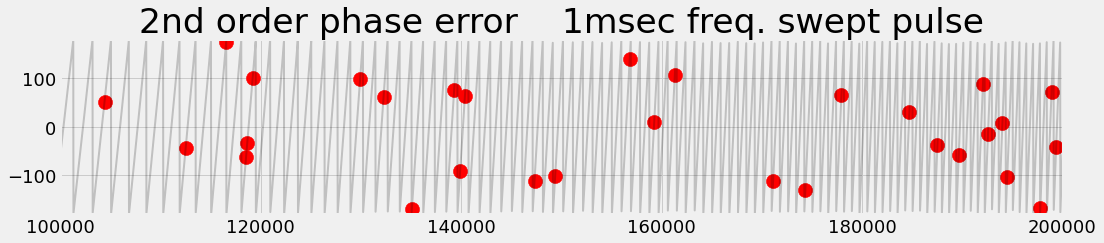

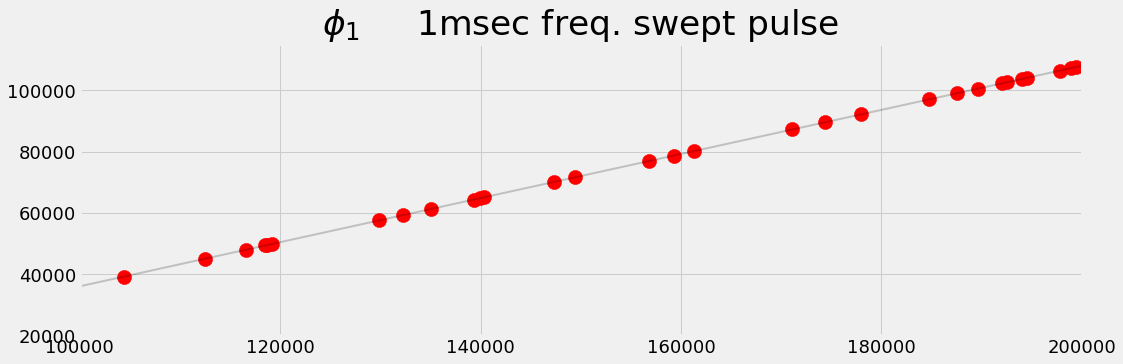

In [19]:
# 1ms pulse
ph1 = -100*360/sw
ph2 = 200*360/sw/sw
phase = (ph0 + ph1*omega +ph2*omega**2)%360 - 180
dphi = sw*(ph1 + 2*ph2*omega)
mz = np.random.randint(5000,10000,30)

figure(figsize=(16,3))
plot(omega, phase, 'k', lw=2, alpha=0.2)
scatter(omega[mz], phase[mz], 200,'r')
plt.title("2nd order phase error    1msec freq. swept pulse")
plt.xlim(xmin=100000, xmax=200000);
plt.ylim(ymin=-180, ymax=+180);

figure(figsize=(16,5))
plot(omega, dphi, 'k', lw=2, alpha=0.2)
scatter(omega[mz], dphi[mz], 200,'r')
plt.title("$\phi_1$     1msec freq. swept pulse")
plt.xlim(xmin=100000, xmax=200000);
plt.ylim(ymin=20000);


do a linear fit of $\phi_1$ , integrate to get $\phi_2$ $\rightarrow$ $\phi_o$ is left to do ! 

works also on sparse spectra

# Phase sensitive FTICR-MS
![](files/s4.png)
- The phase mix the absorption and dispersion linesphapes
- We see a strong linear dependence of phase (here a small spectral window)


## Phase sensitive FTICR-MS
![](files/s3.png)
linear phase correction in not enough

$\Rightarrow$ quadratic phase correction

## Phase sensitive FTICR-MS
interactive/automatic module for FTICR phasing in Spike (not finished yet, but available)
![](files/s6.png)

## Phase sensitive FTICR-MS
![](files/s13-2.png)

## Phase sensitive FTICR-MS
![](files/PH1Molecule.png)

notice the baseline distortion

# the Hilbert transform
relates the *Absorptive* and  *Dispersive* shape

- complex: real / imaginary
    - and time/freq asymmetry
        - due topoint 0 => odd number
    - 3 DFT
        - fft - rfft - fftr
    - causal signal
    - KK
    - Hilbert transform


29 slides

## Beyond Fourier transform
There are MANY alternative to the DFT *(i.e. the numerical handling of the Fourier Transform)*

#### some general principles
-  ALL methods are based on **assumptions** on the signal, and ask a **question** to the data 
<center><b>Important to know them to interpret the answers</b> (and the problems) </center>
- there is no difference between a **spectral method** and a **noise reduction** method. 

There are **Three** famillies of approaches, which differ fundamentaly,<br>
    depending how many parameters $P$ are extracted from the $N$ experimental points (the `fid`) 

Some are known in this community (FDM), some less, some are old (Burg mem 1975), some are very recent...

transform methods are trendy (ML, NN, images ...)

many have advantages ... and defaults !

- not the place to present them
    - give you some hints of useful methods / what they are good for 
    - mostly give you the big principles...



### 3 different famillies
$N$ experimental points / $P$ parameters

- $\mathbf{N>P}$ - **parametric** methods
    - an analytical **model** of the signal is assumed *(sum of damped sinusoids)*
    - the model parameters are **fitted** to the data using some kind of **target function** (usually Mean Squared Error or Maximum Likelihood)
    - the method produces the list of the parameter values
    - **Sinus-it** is an example, (there are many others, FDM, HSVD, Burg,...)
    
- $\mathbf{P>N}$ - **transform** methods *(my naming)*
    - assumptions are introduces indirectly by modeling the **measurement** process, 
    - these assumptions are generally introduced by a **regularisation function**
    - the method produces a graphic / (a spectrum / an image) 
    - there are many examples: **FISTA**, **MaxEnt**, **wavelet**, urQDd, ... 

- $\mathbf{P=N}$ - the **Fourier transform**
    - FT is invertible $\Rightarrow$ just changing of point of view *(no assumption ?)*

## Fourier Transform
#### which assumptions ?
- the signal is zero when I did not measure it
- there is no noise - everything is data
- the spectrum is modeled as a sum of oscillators, regularly placed along the frequency axis
- DFT is the least square solution - and MSE = 0

#### Advantages
- Very fast
- Very stable
- Very well known

#### Drawbacks
- data as a whole $\Rightarrow$ cannot do varying frequency!

- Nyquist - Heisenberg - Gabor

# Nyquist - Heisenberg - Gabor ???

#### Here - 2 signals differing by 0.1 Hz over 10sec : $$0.1 \frac {1}{2 t_{max}}$$

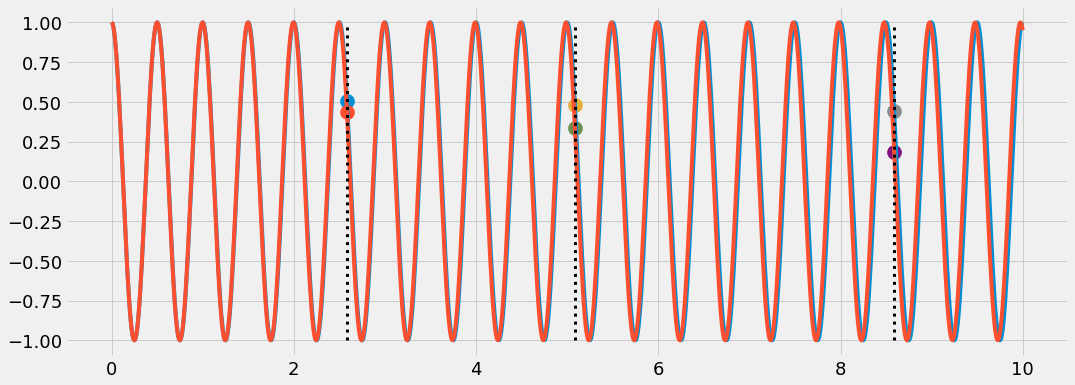

In [20]:
t = linspace(0,10,1000)
f1 = 2
f2 = 2.005
y1 = cos(2*pi*f1*t)
y2 = cos(2*pi*f2*t)
figure(figsize=(16,6))
plot(t, y1)
plot(t, y2)
for io in (258, 508, 858):
    xo = t[io]
    plot([xo,xo],[-1,1],':k',lw=3)
    scatter(xo,y1[io],200)
    scatter(xo,y2[io],200)

it seems that a clever analysis, in high SNR , is able to extract this information

## parametric
- **Advantages**
    - very precise
    - go beyond Gabor and Nyquist limits (continuity assumption)
    - $\Rightarrow$ can do instantaneous frequency!
    - can adapt the model to signal specificities
- **Drawbacks**
    - noise is not in the model *(by definition)* / cannot hardly be handled - in particular complex noise
    - problems with non-standard line-shapes
    - always present nice looking results coherent with the model  *(check your statistics !)*
    - usually slow to very slow *(no Cooley-Tuckey algo !)*
    - non convex problem $\Rightarrow$ MANY methods $\Rightarrow$  which one to choose ?

## transforms
- **Advantages**
    - Very stable - Very well known
    - go beyond Gabor and Nyquist limits $\Rightarrow$ can do instantaneous frequency! (wavelet)
    - strong theoretical background ( $\ell_1$ norm and compressed sensing theorem (Candès - Donoho))
    - noise is in the model $\Rightarrow$  can be used as de-noising
    - can be used along FT ( de-noising, deconvolution, NUS, ...)
    - (near) convex problem $\Rightarrow$ MANY methods $\Rightarrow$  all equivalent in the end ! *(except for the regularisation function)*
- **Drawbacks**
    - not so fast
    - not very well known
    - MANY methods


## Noise reduction - urQRd$^1$ (2014)


An Linear Algebra approach *(known since the `80s)*, based on a new sort of *fast SVD* ...
- Truncate $\mathbf{H}$ first, thanks to *random projection* theorem
&nbsp;  u<span style="color:red">r</span>QRd
- use **QR** to estimate **SVD** from truncated $\mathbf{H}$
&nbsp; &nbsp;  ur<span style="color:red">QR</span>d
- from **QR** decomposition, rebuild $\mathbf{H}$ then $S$
&nbsp; &nbsp;  urQR<span style="color:red">d</span>
- iterate

plus...
- use FFT trick to compute all matrix products.
&nbsp; &nbsp;  <span style="color:red">u</span>rQRd


<small>1.Chiron L., van Agthoven M. A., Kieffer B., Rolando C., Delsuc M-A. *Proc Natl Acad Sci USA*, **111** (4) :1385–1390, (2014)</small>




## example in FT-ICR
![](files/sp1D.png)

## urQRd - speed and robustness compared to Cadzow
on a synthetic dataset

![on a synthetic dataset](files/compo.png)



## compressed sensing 
Here, standard FISTA analysis

example on 64k / 75msec acquisition of ubiquitine

![](files/apo_ai_peak1280.png)

- ion cloud dynamic
    - and line-shape
- beyond FT
    - FT has many drawbacks
- many advantages
- hidden hypothesis
- noise    

    - instantaneous freq
        - FT
        - FDM
        - genetic
          - signal modeling
          - noise handling
          - N>P P>N
        - FISTA
        
        - ...


40 slides